# E-07 뉴스 요약봇 만들기 

### (1) 라이브러리 import 

In [1]:
import nltk
nltk.download('stopwords')

import time
from tqdm import tqdm
import numpy as np
import pandas as pd
import os
import re
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from bs4 import BeautifulSoup 
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
import urllib.request
import warnings


[nltk_data] Downloading package stopwords to /aiffel/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
from importlib.metadata import version
import nltk
import tensorflow
import summa

In [3]:
import urllib.request
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

In [4]:
data.sample(10)

,headlines,text
19970,"'Batti Gul...' is about an issue, 'Padmaavat' ...","Shahid Kapoor, while talking about his films, ..."
52612,Saudi allows women to visit country without a ...,Women aged 25 and above will now be allowed to...
63202,Climbing Uluru monolith in Australia to be ban...,Climbing the Uluru monolith in Australia will ...
67012,Celina Jaitly opens up on losing newborn baby,"Celina Jaitly, while opening up about the deat..."
40481,Most expensive player sold for Ã¢ÂÂ¹1.5cr at ...,Raider Monu Goyat became the costliest player ...
79715,Tata Group seeks details of Air India disinves...,The Tata Group has informally sought details o...
48097,I take these names as medals: K'taka CM on 'ne...,Reacting to JD(S) supremo and former PM HD Dev...
51520,I'll give my wife 7 days to lose pregnancy wei...,US President Donald Trump had said in an inter...
32562,Guys not aware on field more disappointing tha...,CSK skipper MS Dhoni criticised the team for m...
34272,Mother watched me play for 1st time in my last...,Sachin Tendulkar has revealed his mother watch...


### (2) 데이터 전처리하기 : 데이터 정리

In [5]:
print('Text 열에서 중복을 배제한 유일한 샘플의 수 :', data['text'].nunique())
print('Headlines 열에서 중복을 배제한 유일한 샘플의 수 :', data['headlines'].nunique())

Text 열에서 중복을 배제한 유일한 샘플의 수 : 98360
Headlines 열에서 중복을 배제한 유일한 샘플의 수 : 98280


In [6]:
# inplace=True 를 설정하면 DataFrame 타입 값을 return 하지 않고 data 내부를 직접적으로 바꿈
data.drop_duplicates(subset = ['text'], inplace=True)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98360


In [7]:
print(data.isnull().sum())

headlines    0
text         0
dtype: int64


- 데이터프레임에 Null 값은 0 으로 확인

In [8]:
# 텍스트 정규화와 불용어 제거 - 정규화 준비

contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

print("정규화 사전의 수: ", len(contractions))

정규화 사전의 수:  120


In [9]:
print('불용어 개수 :', len(stopwords.words('english') ))
print(stopwords.words('english'))

불용어 개수 : 179
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 's

- 기사 길이 확인 
- 기사들을 띄어쓰기 단위로 나눠서 단어의 갯수들, split()한 리스트의 길이들을 length에 저장한다
- 각 기사의 띄어쓰기 포함, 단순히 string의 길이만 담은 str_length
- np.unique()로 길이들의 고유한 값을 출력해보았다.
- 불용어 처리는 length리스트를 기준으로 44 이하의 길이만 불용어제거를 한다.


In [10]:
from tqdm.notebook import tqdm

In [11]:
length = [len(x.split()) for x in tqdm(data['text'].values)]
str_length = [len(x) for x in tqdm(data['text'].values)]

  0%|          | 0/98360 [00:00<?, ?it/s]

  0%|          | 0/98360 [00:00<?, ?it/s]

In [12]:
np.unique(length)

array([ 1, 38, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54,
       55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 91])

In [13]:
np.unique(str_length)

array([  4, 245, 249, 261, 265, 266, 268, 271, 272, 273, 274, 276, 277,
       278, 280, 281, 282, 283, 284, 285, 286, 287, 288, 289, 290, 291,
       292, 293, 294, 295, 296, 297, 298, 299, 300, 301, 302, 303, 304,
       305, 306, 307, 308, 309, 310, 311, 312, 313, 314, 315, 316, 317,
       318, 319, 320, 321, 322, 323, 324, 325, 326, 327, 328, 329, 330,
       331, 332, 333, 334, 335, 336, 337, 338, 339, 340, 341, 342, 343,
       344, 345, 346, 347, 348, 349, 350, 351, 352, 353, 354, 355, 356,
       357, 358, 359, 360, 361, 362, 363, 364, 365, 366, 367, 368, 369,
       370, 371, 372, 373, 374, 375, 376, 377, 378, 379, 380, 381, 382,
       383, 384, 385, 386, 387, 388, 389, 390, 391, 392, 393, 394, 395,
       396, 397, 398, 399, 400, 401, 402, 403, 404, 405, 406, 407, 408,
       409, 410, 411, 412, 413, 414, 415, 416, 417, 418, 419, 420, 421,
       422, 423, 424, 425, 427, 428, 429, 430, 431, 432, 433, 434, 438,
       439, 442, 444, 459, 513])

In [14]:
head_length = [len(x.split()) for x in tqdm(data['headlines'].values)]
head_str_length = [len(x) for x in tqdm(data['headlines'].values)]

  0%|          | 0/98360 [00:00<?, ?it/s]

  0%|          | 0/98360 [00:00<?, ?it/s]

In [15]:
np.unique(head_length)

array([ 1,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 18])

In [16]:
np.unique(head_str_length)

array([ 9, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45,
       46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62,
       63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79,
       80, 82, 83, 84, 86])

In [17]:
# 데이터 전처리 함수
def preprocess_sentence(sentence, remove_stopwords=True):
    sentence = sentence.lower() # 텍스트 소문자화
    sentence = BeautifulSoup(sentence, "lxml").text # <br />, <a href = ...> 등의 html 태그 제거
    sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열 (...) 제거 Ex) my husband (and myself!) for => my husband for
    sentence = re.sub('"','', sentence) # 쌍따옴표 " 제거
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 약어 정규화
    sentence = re.sub(r"'s\b","", sentence) # 소유격 제거. Ex) roland's -> roland
    sentence = re.sub("[^a-zA-Z]", " ", sentence) # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    sentence = re.sub('[m]{2,}', 'mm', sentence) # m이 3개 이상이면 2개로 변경. Ex) ummmmmmm yeah -> umm yeah
    
    # 불용어 제거 (Text)
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
    # 불용어 미제거 (Summary)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens

In [18]:
clean_text = []

# 전체 Text 데이터에 대한 전처리 : 10분 이상 시간이 걸릴 수 있습니다. 
for s in tqdm(data['text']):
    clean_text.append(preprocess_sentence(s))

# 전처리 후 출력
print("Text 전처리 후 결과: ", clean_text[:5])

  0%|          | 0/98360 [00:00<?, ?it/s]

Text 전처리 후 결과:  ['saurav kant alumnus upgrad iiit pg program machine learning artificial intelligence sr systems engineer infosys almost years work experience program upgrad degree career support helped transition data scientist tech mahindra salary hike upgrad online power learning powered lakh careers', 'kunal shah credit card bill payment platform cred gave users chance win free food swiggy one year pranav kaushik delhi techie bagged reward spending cred coins users get one cred coin per rupee bill paid used avail rewards brands like ixigo bookmyshow ubereats cult fit', 'new zealand defeated india wickets fourth odi hamilton thursday win first match five match odi series india lost international match rohit sharma captaincy consecutive victories dating back march match witnessed india getting seventh lowest total odi cricket history', 'aegon life iterm insurance plan customers enjoy tax benefits premiums paid save taxes plan provides life cover age years also customers options insur

In [19]:
clean_headlines = []

# 전체 Summary 데이터에 대한 전처리 : 5분 이상 시간이 걸릴 수 있습니다. 
for s in tqdm(data['headlines']):
    clean_headlines.append(preprocess_sentence(s, False))

print("Summary 전처리 후 결과: ", clean_headlines[:5])

  0%|          | 0/98360 [00:00<?, ?it/s]

Summary 전처리 후 결과:  ['upgrad learner switches to career in ml al with salary hike', 'delhi techie wins free food from swiggy for one year on cred', 'new zealand end rohit sharma led india match winning streak', 'aegon life iterm insurance plan helps customers save tax', 'have known hirani for yrs what if metoo claims are not true sonam']


In [20]:
data.isnull().sum()

headlines    0
text         0
dtype: int64

- Null 값은 0 이므로 dropna 는 사용하지 않아도 됨 

### (3) 데이터 전처리 : 훈련데이터와 테스트데이터 나누기

텍스트의 최소 길이 : 1
텍스트의 최대 길이 : 91
텍스트의 평균 길이 : 58.23813542090281
요약의 최소 길이 : 1
요약의 최대 길이 : 18
요약의 평균 길이 : 9.553660024400163


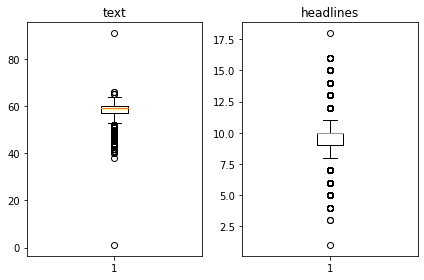

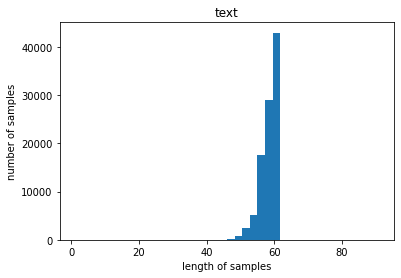

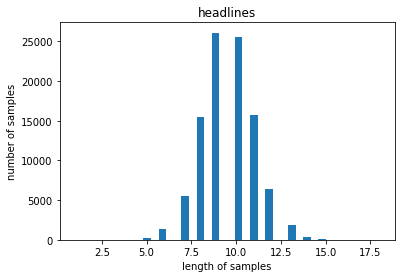

In [21]:
# 길이 분포 출력
import matplotlib.pyplot as plt

text_len = [len(s.split()) for s in data['text']]
summary_len = [len(s.split()) for s in data['headlines']]

print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))
print('요약의 최소 길이 : {}'.format(np.min(summary_len)))
print('요약의 최대 길이 : {}'.format(np.max(summary_len)))
print('요약의 평균 길이 : {}'.format(np.mean(summary_len)))

plt.subplot(1,2,1)
plt.boxplot(text_len)
plt.title('text')
plt.subplot(1,2,2)
plt.boxplot(summary_len)
plt.title('headlines')
plt.tight_layout()
plt.show()

plt.title('text')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('headlines')
plt.hist(summary_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [22]:
text_max_len = 60
summary_max_len = 12

In [23]:
def below_threshold_len(max_len, nested_list):
    cnt = 0
    for s in nested_list:
        if(len(s.split()) <= max_len):
            cnt = cnt + 1
    print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))))

In [24]:
below_threshold_len(text_max_len, data['text'])
below_threshold_len(summary_max_len,  data['headlines'])

전체 샘플 중 길이가 60 이하인 샘플의 비율: 0.997448149654331
전체 샘플 중 길이가 12 이하인 샘플의 비율: 0.9768198454656364


In [25]:
data = data[data['text'].apply(lambda x: len(x.split()) <= text_max_len)]
data = data[data['headlines'].apply(lambda x: len(x.split()) <= summary_max_len)]
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 95838


In [26]:
# 요약 데이터에는 시작 토큰과 종료 토큰을 추가한다.
data['decoder_input'] = data['headlines'].apply(lambda x : 'sostoken '+ x)
data['decoder_target'] = data['headlines'].apply(lambda x : x + ' eostoken')
data.head()

,headlines,text,decoder_input,decoder_target
1,Delhi techie wins free food from Swiggy for on...,Kunal Shah's credit card bill payment platform...,sostoken Delhi techie wins free food from Swig...,Delhi techie wins free food from Swiggy for on...
2,New Zealand end Rohit Sharma-led India's 12-ma...,New Zealand defeated India by 8 wickets in the...,sostoken New Zealand end Rohit Sharma-led Indi...,New Zealand end Rohit Sharma-led India's 12-ma...
3,Aegon life iTerm insurance plan helps customer...,"With Aegon Life iTerm Insurance plan, customer...",sostoken Aegon life iTerm insurance plan helps...,Aegon life iTerm insurance plan helps customer...
5,Rahat Fateh Ali Khan denies getting notice for...,Pakistani singer Rahat Fateh Ali Khan has deni...,sostoken Rahat Fateh Ali Khan denies getting n...,Rahat Fateh Ali Khan denies getting notice for...
7,Govt directs Alok Verma to join work 1 day bef...,Weeks after ex-CBI Director Alok Verma told th...,sostoken Govt directs Alok Verma to join work ...,Govt directs Alok Verma to join work 1 day bef...


In [27]:
# 인코더의 입력, 디코더의 입력과 레이블을 각각 다시 Numpy 타입으로 저장해 주기 

encoder_input = np.array(data['text']) # 인코더의 입력
decoder_input = np.array(data['decoder_input']) # 디코더의 입력
decoder_target = np.array(data['decoder_target']) # 디코더의 레이블

In [28]:
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)
print(indices)

[34122 40222 44610 ... 23364 74849 52323]


In [29]:
# encoder_input과 크기와 형태가 같은 순서가 섞인 정수 시퀀스를 만들기 

ndices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)
print(indices)

[ 4981 11300 77472 ... 92724 65305 68189]


In [30]:
# 다시 데이터의 샘플 순서를 정의해 주기 

encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]

In [31]:
# 전체 데이터의 크기에서 0.2 를 곱해서 테스트 데이터의 크기를 정의 

n_of_val = int(len(encoder_input)*0.2)
print('테스트 데이터의 수 :', n_of_val)

테스트 데이터의 수 : 19167


In [32]:
encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

훈련 데이터의 개수 : 76671
훈련 레이블의 개수 : 76671
테스트 데이터의 개수 : 19167
테스트 레이블의 개수 : 19167


### (4) 데이터 전처리 : 정수 인코딩 


In [33]:
src_tokenizer = Tokenizer() # 토크나이저 정의
src_tokenizer.fit_on_texts(encoder_input_train) # 입력된 데이터로부터 단어 집합 생성
src_tokenizer.word_index

{'the': 1,
 'to': 2,
 'a': 3,
 'in': 4,
 'of': 5,
 'and': 6,
 'on': 7,
 'has': 8,
 'for': 9,
 'said': 10,
 'that': 11,
 'was': 12,
 'is': 13,
 'he': 14,
 'by': 15,
 'with': 16,
 'his': 17,
 'after': 18,
 'from': 19,
 'as': 20,
 'it': 21,
 'at': 22,
 'will': 23,
 'an': 24,
 'be': 25,
 'have': 26,
 'had': 27,
 'who': 28,
 'been': 29,
 'which': 30,
 'added': 31,
 'year': 32,
 'her': 33,
 'were': 34,
 'this': 35,
 'its': 36,
 'over': 37,
 'not': 38,
 'india': 39,
 'also': 40,
 'us': 41,
 'are': 42,
 'she': 43,
 'their': 44,
 'i': 45,
 'while': 46,
 'against': 47,
 'first': 48,
 'police': 49,
 'people': 50,
 'about': 51,
 'government': 52,
 'indian': 53,
 'two': 54,
 'old': 55,
 'they': 56,
 'crore': 57,
 'minister': 58,
 'president': 59,
 'film': 60,
 'him': 61,
 'one': 62,
 'further': 63,
 'during': 64,
 'up': 65,
 '000': 66,
 'court': 67,
 'when': 68,
 'reportedly': 69,
 'all': 70,
 'years': 71,
 'state': 72,
 'new': 73,
 'out': 74,
 'being': 75,
 'former': 76,
 'time': 77,
 'would': 78,

In [34]:
threshold = 7
total_cnt = len(src_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in src_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 90347
등장 빈도가 6번 이하인 희귀 단어의 수: 65921
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 24426
단어 집합에서 희귀 단어의 비율: 72.96423788282954
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 2.780519072258382


In [35]:
src_vocab = 24000
src_tokenizer = Tokenizer(num_words=src_vocab) # 단어 집합의 크기를 8,000으로 제한
src_tokenizer.fit_on_texts(encoder_input_train) # 단어 집합 재생성

In [36]:
# 텍스트 시퀀스를 정수 시퀀스로 변환
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train) 
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

# 잘 진행되었는지 샘플 출력
print(encoder_input_train[:3])

[[3197, 1, 888, 344, 1924, 1456, 2200, 2, 13446, 2961, 6, 21276, 445, 7, 168, 1985, 5578, 59, 5979, 4650, 139, 35, 13, 251, 56, 2177, 68, 56, 10, 8115, 14319, 3162, 770, 787, 13, 1515, 6, 3064, 2, 3715, 14, 63, 10, 4, 3017, 2, 3162, 5164], [522, 89, 314, 786, 186, 22696, 8, 1712, 3413, 89, 314, 786, 6, 926, 3460, 4, 3, 762, 6, 1264, 342, 23, 869, 2, 3596, 9366, 274, 1, 2201, 633, 4, 870, 15, 3098, 2143, 205, 16, 2380, 4072, 2, 246, 94, 4397, 9, 4398, 265, 1194, 2962, 142, 15960, 2350, 6, 1360], [41, 14825, 1804, 8, 1007, 2, 1122, 1952, 15374, 432, 1274, 9, 206, 126, 134, 8004, 66, 57, 15374, 30, 3065, 358, 1108, 17305, 1192, 13, 609, 2, 852, 36, 1470, 167, 1, 423, 234, 134, 2201, 5, 871, 3251, 1804, 2677, 181, 1, 342, 2453, 3, 1108, 1094, 4, 1, 41, 1450]]


- 토큰화 진행

In [37]:
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)

In [38]:
threshold = 6
total_cnt = len(tar_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 40368
등장 빈도가 5번 이하인 희귀 단어의 수: 29233
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 11135
단어 집합에서 희귀 단어의 비율: 72.4162703131193
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 6.316580019978563


In [39]:
tar_vocab = 11000
tar_tokenizer = Tokenizer(num_words=tar_vocab) 
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train) 
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

# 잘 변환되었는지 확인
print('input')
print('input ',decoder_input_train[:5])
print('target')
print('decoder ',decoder_target_train[:5])

input
input  [[1, 6145, 6145, 47, 2024, 7, 24, 5868, 727, 197, 1585], [1, 4684, 844, 350, 1468, 3421], [1, 949, 3, 427, 348, 1483, 5, 70, 29, 287], [1, 330, 70, 343, 75, 4, 433, 8, 1686, 4, 898], [1, 1389, 7563, 8076, 9347, 4007, 767, 8077]]
target
decoder  [[6145, 6145, 47, 2024, 7, 24, 5868, 727, 197, 1585, 2], [4684, 844, 350, 1468, 3421, 2], [949, 3, 427, 348, 1483, 5, 70, 29, 287, 2], [330, 70, 343, 75, 4, 433, 8, 1686, 4, 898, 2], [1389, 7563, 8076, 9347, 4007, 767, 8077, 2]]


In [40]:
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('삭제할 훈련 데이터의 개수 :', len(drop_train))
print('삭제할 테스트 데이터의 개수 :', len(drop_test))

encoder_input_train = [sentence for index, sentence in enumerate(encoder_input_train) if index not in drop_train]
decoder_input_train = [sentence for index, sentence in enumerate(decoder_input_train) if index not in drop_train]
decoder_target_train = [sentence for index, sentence in enumerate(decoder_target_train) if index not in drop_train]

encoder_input_test = [sentence for index, sentence in enumerate(encoder_input_test) if index not in drop_test]
decoder_input_test = [sentence for index, sentence in enumerate(decoder_input_test) if index not in drop_test]
decoder_target_test = [sentence for index, sentence in enumerate(decoder_target_test) if index not in drop_test]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

삭제할 훈련 데이터의 개수 : 0
삭제할 테스트 데이터의 개수 : 0
훈련 데이터의 개수 : 76671
훈련 레이블의 개수 : 76671
테스트 데이터의 개수 : 19167
테스트 레이블의 개수 : 19167


In [41]:
encoder_input_train = pad_sequences(encoder_input_train, maxlen=text_max_len, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen=text_max_len, padding='post')
decoder_input_train = pad_sequences(decoder_input_train, maxlen=summary_max_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen=summary_max_len, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen=summary_max_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen=summary_max_len, padding='post')

### (5) 모델 설계하기 

In [42]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


# 인코더 설계 시작
embedding_dim = 128
hidden_size = 256

# 인코더
encoder_inputs = Input(shape=(text_max_len,))

# 인코더의 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

# 인코더의 LSTM 1
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4, recurrent_dropout = 0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# 인코더의 LSTM 2
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# 인코더의 LSTM 3
encoder_lstm3 = LSTM(hidden_size, return_state=True, return_sequences=True, dropout=0.4, recurrent_dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

In [43]:
# 디코더 설계
decoder_inputs = Input(shape=(None,))

# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# 디코더의 LSTM
decoder_lstm = LSTM(hidden_size, return_sequences = True, return_state = True, dropout = 0.4, recurrent_dropout=0.2)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state = [state_h, state_c])

In [44]:
# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_outputs) 



In [45]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/thushv89/attention_keras/master/src/layers/attention.py", filename="attention.py")
from attention import AttentionLayer

In [46]:
from tensorflow.keras.layers import AdditiveAttention

# 어텐션 층(어텐션 함수)
attn_layer = AdditiveAttention(name='attention_layer')

# 인코더와 디코더의 모든 time step의 hidden state를 어텐션 층에 전달하고 결과를 리턴
attn_out = attn_layer([decoder_outputs, encoder_outputs])


# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 60)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 60, 128)      3072000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 60, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

### (6) 모델 훈련하기

In [47]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience = 2)
history = model.fit(x = [encoder_input_train, decoder_input_train], y = decoder_target_train, \
          validation_data = ([encoder_input_test, decoder_input_test], decoder_target_test),
          batch_size = 256, callbacks=[es], epochs = 50)

Epoch 1/50
300/300 [==============================] - 245s 786ms/step - loss: 5.8754 - val_loss: 5.4582
Epoch 2/50
300/300 [==============================] - 236s 788ms/step - loss: 5.3478 - val_loss: 5.0539
Epoch 3/50
300/300 [==============================] - 236s 785ms/step - loss: 4.9595 - val_loss: 4.7714
Epoch 4/50
300/300 [==============================] - 245s 816ms/step - loss: 4.6781 - val_loss: 4.5577
Epoch 5/50
300/300 [==============================] - 273s 910ms/step - loss: 4.4628 - val_loss: 4.4192
Epoch 6/50
300/300 [==============================] - 275s 916ms/step - loss: 4.2870 - val_loss: 4.2938
Epoch 7/50
300/300 [==============================] - 277s 924ms/step - loss: 4.1324 - val_loss: 4.1907
Epoch 8/50
300/300 [==============================] - 276s 919ms/step - loss: 4.0004 - val_loss: 4.1194
Epoch 9/50
300/300 [==============================] - 236s 788ms/step - loss: 3.8848 - val_loss: 4.0539
Epoch 10/50
300/300 [==============================] - 232s 775m

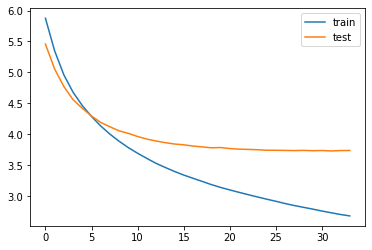

In [48]:
# 시각화 
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

### (7) 실제 결과와 요약문 비교 : Inference 모델 구현

In [49]:
src_index_to_word = src_tokenizer.index_word # 원문 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_tokenizer.word_index # 요약 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word = tar_tokenizer.index_word # 요약 단어 집합에서 정수 -> 단어를 얻음

In [50]:
# 인코더 설계
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)

# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

In [51]:
# 어텐션 함수
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf = attn_layer([decoder_outputs2, decoder_hidden_state_input])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat) 

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

In [52]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

     # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if (sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (summary_max_len-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        e_h, e_c = h, c

    return decoded_sentence

### (8) 모델 테스트

In [53]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if (i!=0):
            temp = temp + src_index_to_word[i]+' '
    return temp

# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2summary(input_seq):
    temp=''
    for i in input_seq:
        if ((i!=0 and i!=tar_word_to_index['sostoken']) and i!=tar_word_to_index['eostoken']):
            temp = temp + tar_index_to_word[i] + ' '
    return temp

In [54]:
for i in range(50, 100):
    print("원문 :", seq2text(encoder_input_test[i]))
    print("실제 요약 :", seq2summary(decoder_input_test[i]))
    print("예측 요약 :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("\n")

원문 : over ã¢ââ¹6 lakh has been stolen from 13 victims at delhi's cafãâ© after an employee took customers' debit or credit cards on the pretext of getting the card machine and cloned them this was unearthed when hdfc bank approached the police about the cloning of cards with 13 such cases happening with the customers 
실제 요약 : ã¢ââ¹6 lakh stolen from debit cards at delhi cafe 
예측 요약 :  uber fined ã¢ââ¹10 lakh for stolen from atm


원문 : the 19 year old man who was arrested on friday for killing a 6 year old boy had lied about the motive behind the murder the accused who claimed to have killed the boy in a fit of rage for at his wife while she originally planned to kidnap the child to seek a ã¢ââ¹20 000 ransom from his parents 
실제 요약 : delhi man killed 6 yr old for ransom not for at wife 
예측 요약 :  man kills minor boy who killed her murder


원문 : us president donald trump on thursday signed a resolution passed by the congress condemning white supremacists and other hate groups the reso

### (9) 추출적 요약


In [55]:
import requests
from summa.summarizer import summarize

In [56]:
data.head()

,headlines,text,decoder_input,decoder_target
1,Delhi techie wins free food from Swiggy for on...,Kunal Shah's credit card bill payment platform...,sostoken Delhi techie wins free food from Swig...,Delhi techie wins free food from Swiggy for on...
2,New Zealand end Rohit Sharma-led India's 12-ma...,New Zealand defeated India by 8 wickets in the...,sostoken New Zealand end Rohit Sharma-led Indi...,New Zealand end Rohit Sharma-led India's 12-ma...
3,Aegon life iTerm insurance plan helps customer...,"With Aegon Life iTerm Insurance plan, customer...",sostoken Aegon life iTerm insurance plan helps...,Aegon life iTerm insurance plan helps customer...
5,Rahat Fateh Ali Khan denies getting notice for...,Pakistani singer Rahat Fateh Ali Khan has deni...,sostoken Rahat Fateh Ali Khan denies getting n...,Rahat Fateh Ali Khan denies getting notice for...
7,Govt directs Alok Verma to join work 1 day bef...,Weeks after ex-CBI Director Alok Verma told th...,sostoken Govt directs Alok Verma to join work ...,Govt directs Alok Verma to join work 1 day bef...


In [57]:
input_text = data['text']
print(input_text[:1500])

1       Kunal Shah's credit card bill payment platform...
2       New Zealand defeated India by 8 wickets in the...
3       With Aegon Life iTerm Insurance plan, customer...
5       Pakistani singer Rahat Fateh Ali Khan has deni...
7       Weeks after ex-CBI Director Alok Verma told th...
                              ...                        
1600    France has triggered a plan for a no-deal Brex...
1601    Chinese TV programmes appeared to be censoring...
1603    Canada's 67-year-old poker player Scott Wellen...
1606    Washington's 27-year-old Nick Naydev jumped st...
1608    Citing an investigative news report, Congress ...
Name: text, Length: 1500, dtype: object


In [58]:
input_text[10]

"Two minor cousins in Uttar Pradesh's Gorakhpur were allegedly repeatedly burnt with tongs and forced to eat human excreta by their family for being friends with two boys from the same school. The cousins revealed their ordeal to the police and Child Welfare Committee after being brought back to Gorakhpur from Nepal, where they had fled to escape the torture."

In [59]:
for _ in range(10) :
    rnum = np.random.randint(len(input_text))
    print(f'Original Sentence:\n{input_text[rnum]}\n')
    print(f'Summary:\n{summarize(input_text[rnum], ratio=0.4)}')
    print('--'*50+'\n\n')

Original Sentence:
In an unprecedented court martial held in both UK and USA, British Lieutenant Colonel Benedict Tomkins has been accused of raping an intoxicated US military colleague at a UN conference held in Uganda. However, the British officer has denied the accusations and alleged that the US officer was creating the story to make up for her professional shortcomings.

Summary:

----------------------------------------------------------------------------------------------------


Original Sentence:
Former India captain Sunil Gavaskar has alleged that selectors' "deep-set bias" is denying players from Mumbai opportunities to play for India's national sides. Gavaskar cited the example of batsman Siddhesh Lad, who hasn't earned a call-up to the India 'A' squad despite his consistency in domestic cricket. He added that Indian cricket suffers with such biased and myopic decisions. 

Summary:
Gavaskar cited the example of batsman Siddhesh Lad, who hasn't earned a call-up to the India 

# 회고

#### 목표 

1. Abstractive 모델 구성을 위한 텍스트 전처리 :  분석단계, 정제단계, 정규화와 불용어 제거, 데이터셋 분리, 인코딩 과정 체계적으로 진행

2. 텍스트 요약모델 학습 : 모델학습이 안정적으로 수렴되었음을 그래프를 통해 확인하고 실제 요약문과 유사한 요약문장을 얻기

3. Extractive 요약 결과와 Abstractive 요약 결과 비교 : 두 요약 결과를 문법완성도 측면과 핵심단어 포함 측면으로 나누어 비교분석 결과를 제시
<br> 
<br>



- 뉴스 데이터 요약을 두가지 방식으로 진행해 보았다. 
    1. 추상적 요약 : Attenttion 매터니즘 활용 / LSTM을 사용 / Encoder -> Decoder / 앞의 결과와 Attention층을 연결하여 결과 도출
    2. 추출적 요약 : `Summa` 를 활용하여 진행  
        <br>  
        
        
- 데이터 전처리
        
    - 인코더의 입력 데이터 중 길이가 44 이하인 경우는 불용어 제거를 하지 않고 그대로 전처리만 적용 하였다.   
    
    - 입력데이터의 길이는 다음과 같다 : 
        - [ 1, 38, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 91]
        <br>  
        
        
- 안정적인 학습 그래프가 나왔고 학습 결과 loss값은 다음과 같다 : 
    - Epoch 34/50
[300/300 [==============================] - 240s 801ms/step - loss: 2.6788 - val_loss: 3.7373] 
    
    - Validation에 대한 loss값은 많이 줄지 않았는데 데이터 전처리와 학습률 변경을 통해 더 나아질 것으로 예상한다. 
    <br> 
        
        
- 추상적 요약문의 경우 loss결과를 봐서 예상이 가능하듯이 요약문에서 사용되는 단어는 어느정도 포함이 되어 있어 학습이 진행된 것은 알수 있지만 문법완성도에 따른 전체적인 뜻은 본문의 뜻을 잘 요약했다고는 볼 수 없다.  
 <br> 

- 추출적 요약문의 경우 문법완성도와 핵심단어 포함 측면에서 전체적으로 추상적 요약문 보다는 좀 더 낫다고 보이지만 중간중간에 아예 summary 가 공란인 부분이 있어 이 부분은 시간이 좀 더 있었다면 해결해 보려고 했을것이다. 추출적 요약문 경우 ```ratio```가 0.4보다 작아질 경우 결과가 제대로 나오지 않았다. 